In [43]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

In [44]:
import os
for dirname, _, filenames in os.walk('input.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [45]:
data_movie = pd.read_csv("movie.csv")
data_rating = pd.read_csv("rating.csv")

In [46]:
print("Movies Dataset Overview:")
print(data_movie.head())
print("\nRatings Dataset Overview:")
print(data_rating.head())

Movies Dataset Overview:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Dataset Overview:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


In [47]:
print("\nMissing Values in Movies Dataset:")
print(data_movie.isnull().sum())
print("\nMissing Values in Ratings Dataset:")
print(data_rating.isnull().sum())


Missing Values in Movies Dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Ratings Dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [48]:
print("\nDescriptive Statistics of Ratings:")
print(data_rating['rating'].describe())


Descriptive Statistics of Ratings:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


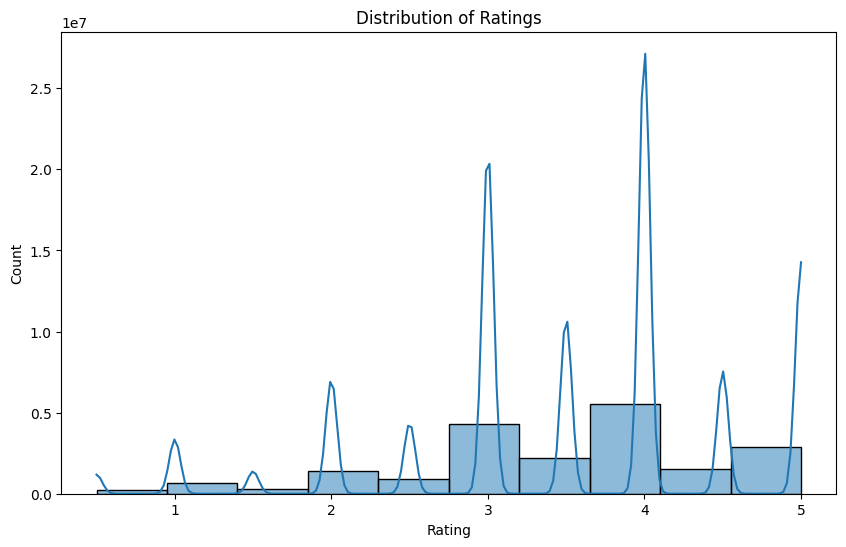

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(data_rating['rating'], bins=10, kde=True)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

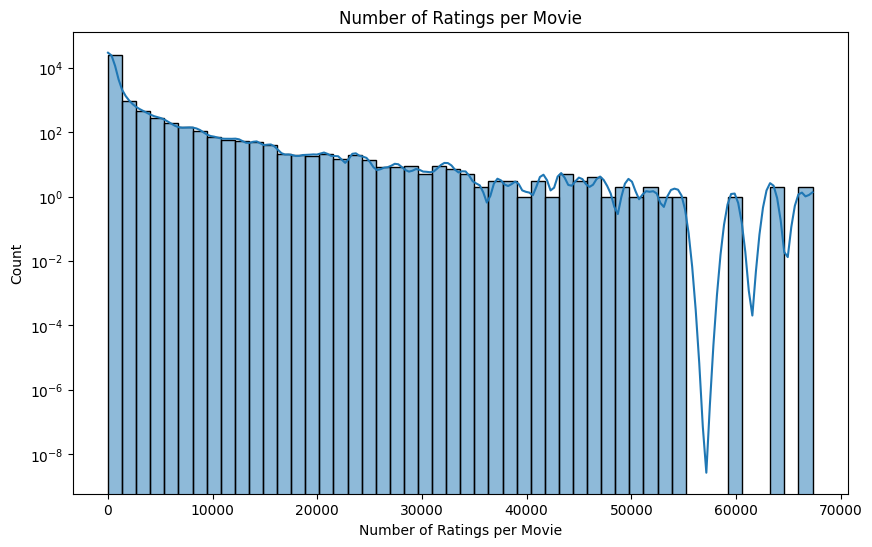

In [50]:
ratings_per_movie = data_rating.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Count')
plt.title('Number of Ratings per Movie')
plt.yscale('log')
plt.show()

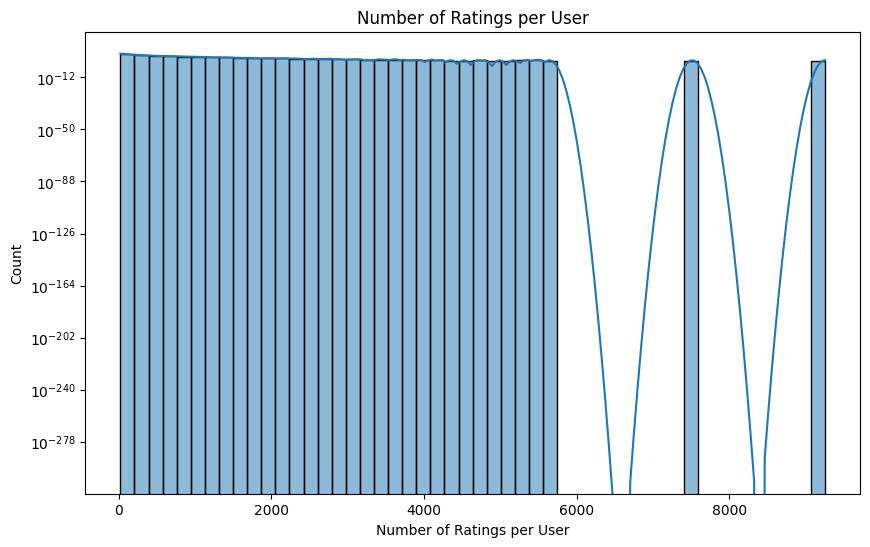

In [51]:
ratings_per_user = data_rating.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Count')
plt.title('Number of Ratings per User')
plt.yscale('log')
plt.show()


In [52]:
movie = data_movie.loc[:, ["movieId", "title"]]
rating = data_rating.loc[:, ["userId", "movieId", "rating"]]
data = pd.merge(movie, rating)

In [53]:
data = data.iloc[:1000000, :]

In [54]:
user_movie_table = data.pivot_table(index=["title"], columns=["userId"], values="rating").fillna(0)
print("\nUser-Movie Pivot Table Sample:")
print(user_movie_table.head(10))


User-Movie Pivot Table Sample:
userId                                 1       2       3       4       5       \
title                                                                           
Ace Ventura: When Nature Calls (1995)     0.0     0.0     0.0     3.0     0.0   
Across the Sea of Time (1995)             0.0     0.0     0.0     0.0     0.0   
Amazing Panda Adventure, The (1995)       0.0     0.0     0.0     0.0     0.0   
American President, The (1995)            0.0     0.0     0.0     0.0     5.0   
Angela (1995)                             0.0     0.0     0.0     0.0     0.0   
Angels and Insects (1995)                 0.0     0.0     0.0     0.0     0.0   
Anne Frank Remembered (1995)              0.0     0.0     0.0     0.0     0.0   
Antonia's Line (Antonia) (1995)           0.0     0.0     0.0     0.0     0.0   
Assassins (1995)                          0.0     0.0     0.0     0.0     0.0   
Babe (1995)                               0.0     0.0     0.0     0.0     0.0

In [55]:
query_index = np.random.choice(user_movie_table.shape[0])
print("\nChosen Movie is:", user_movie_table.index[query_index])


Chosen Movie is: Carrington (1995)


In [56]:
user_movie_table_matrix = csr_matrix(user_movie_table.values)

In [57]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_movie_table_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [58]:
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

In [59]:
movie = []
distance = []
for i in range(1, len(distances.flatten())):
    if i != 0:
        movie.append(user_movie_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])

m = pd.Series(movie, name='movie')
d = pd.Series(distance, name='distance')
recommend = pd.concat([m, d], axis=1)
recommend = recommend.sort_values('distance', ascending=False)

# Display Recommendations
print('\nRecommendations for {0}:\n'.format(user_movie_table.index[query_index]))
for i in range(0, recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["movie"].iloc[i], recommend["distance"].iloc[i]))



Recommendations for Carrington (1995):

0: Brothers McMullen, The (1995), with distance of 0.8105027316084974
1: Postman, The (Postino, Il) (1994), with distance of 0.8100229781898888
2: Sense and Sensibility (1995), with distance of 0.7998303970837419
3: Angels and Insects (1995), with distance of 0.7658213187578096
4: Persuasion (1995), with distance of 0.759744840084545


In [60]:
test_users = np.random.choice(user_movie_table.columns, size=100, replace=False)

In [61]:
# Calculate RMSE for the test users
test_data = user_movie_table[test_users]
test_sparse_matrix = csr_matrix(test_data.values)

In [62]:
predictions = []
actual = []

for user in test_users:
    user_ratings = test_data[user]
    non_zero_ratings = user_ratings[user_ratings > 0].index

    for movie in non_zero_ratings:
        movie_index = user_movie_table.index.get_loc(movie)
        distances, indices = model_knn.kneighbors(user_movie_table_matrix[movie_index, :].reshape(1, -1), n_neighbors=6)

        # Take the mean rating of the neighbors as the predicted rating
        neighbors_indices = indices.flatten()[1:]
        predicted_rating = np.mean([user_movie_table.iloc[i, user_movie_table.columns.get_loc(user)] for i in neighbors_indices])

        predictions.append(predicted_rating)
        actual.append(user_ratings[movie])

In [63]:
rmse = np.sqrt(mean_squared_error(actual, predictions))
print("\nRoot Mean Squared Error (RMSE) for the Recommendation System: {:.4f}".format(rmse))


Root Mean Squared Error (RMSE) for the Recommendation System: 2.2759


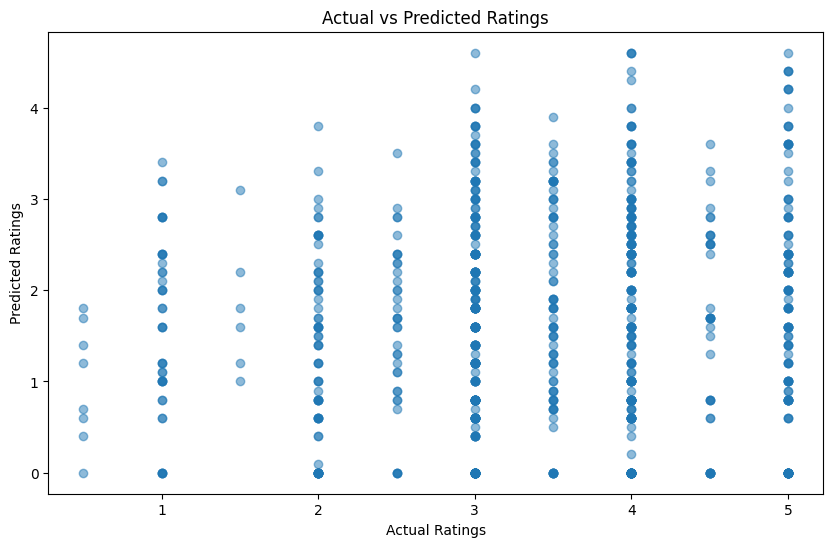

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import Binarizer


In [66]:
threshold = 4.0  # Relevant if rating >= threshold
k = 5 # Top k recommended items to consider for precision and recall

In [67]:
# Convert actual and predicted ratings into binary values for relevant (1) and not relevant (0)
binarizer = Binarizer(threshold=threshold)

In [68]:
actual_binary = binarizer.fit_transform(np.array(actual).reshape(-1, 1)).ravel()
predictions_binary = binarizer.transform(np.array(predictions).reshape(-1, 1)).ravel()


In [69]:
accuracy = accuracy_score(actual_binary, predictions_binary)
print("\nAccuracy: {:.4f}".format(accuracy))



Accuracy: 0.8087


In [70]:
precision = precision_score(actual_binary, predictions_binary)
recall = recall_score(actual_binary, predictions_binary)
print("\nPrecision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


Precision: 0.5000
Recall: 0.0429


In [71]:
# Calculate ROC and AUC
fpr, tpr, _ = roc_curve(actual_binary, predictions)
roc_auc = auc(fpr, tpr)
print("Area Under the Curve (AUC): {:.4f}".format(roc_auc))

Area Under the Curve (AUC): 0.5153


In [72]:
# Visualize Precision, Recall, ROC, and AUC
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, 'Precision and Recall')

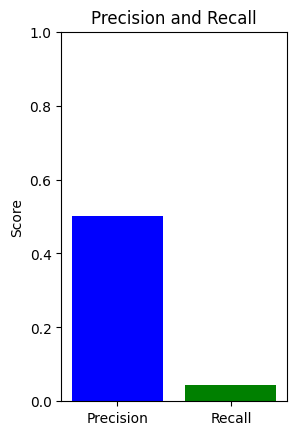

In [73]:
# Plotting Precision and Recall
plt.subplot(1, 2, 1)
plt.bar(['Precision', 'Recall'], [precision, recall], color=['blue', 'green'])
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Precision and Recall')

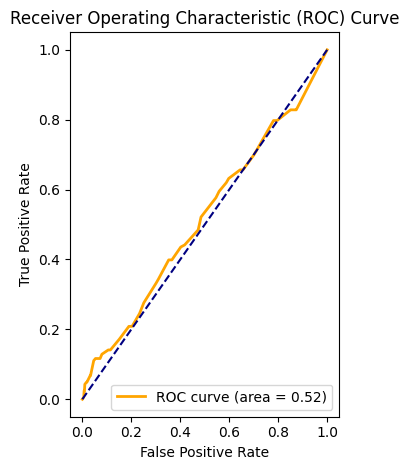

In [74]:
# Plotting ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()